In [1]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
import tensorflow as tf

from sklearn.inspection import permutation_importance










In [2]:
import pandas as pd

# Load dataset
file_path = "/content/ToN_IoT_preprocessed.csv"  # Replace with actual file path
data = pd.read_csv(file_path)

# Print column names
print("Column names in the dataset:", data.columns)


Column names in the dataset: Index(['ts', 'src_ip', 'src_port', 'dst_ip', 'dst_port', 'proto', 'service',
       'duration', 'src_bytes', 'dst_bytes', 'conn_state', 'missed_bytes',
       'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes', 'dns_query',
       'dns_qclass', 'dns_qtype', 'dns_rcode', 'dns_AA', 'dns_RD', 'dns_RA',
       'dns_rejected', 'ssl_version', 'ssl_cipher', 'ssl_resumed',
       'ssl_established', 'ssl_subject', 'ssl_issuer', 'http_trans_depth',
       'http_method', 'http_uri', 'http_version', 'http_request_body_len',
       'http_response_body_len', 'http_status_code', 'http_user_agent',
       'http_orig_mime_types', 'http_resp_mime_types', 'weird_name',
       'weird_addl', 'weird_notice', 'type'],
      dtype='object')


In [9]:
# Load dataset
def load_dataset(path):
    data = pd.read_csv(path)
    return data

# Preprocess data
def preprocess_data(data):
    X = data.iloc[:, :-1]
    y = data['type']

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    return pd.DataFrame(X_scaled, columns=X.columns), y

# Handle class imbalance with SMOTE
def balance_data(X, y):
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

In [4]:
# from sklearn.ensemble import RandomForestClassifier

# def feature_selection(X, y):
#     model = RandomForestClassifier(n_estimators=10, random_state=42)
#     model.fit(X, y)

#     explainer = shap.TreeExplainer(model, check_additivity=False)  # Disable additivity check
#     shap_values = explainer.shap_values(X)

#     shap_importance = np.abs(shap_values).mean(axis=0)
#     feature_ranking = pd.Series(shap_importance, index=X.columns).sort_values(ascending=False)

#     top_features = feature_ranking.head(15).index.tolist()
#     print("Selected Features:", top_features)

#     return X[top_features], top_features


In [5]:
# Feature selection using Permutation Feature Importance (PFI) with Visualization
def feature_selection(X, y):
    model = RandomForestClassifier(n_estimators=10, random_state=42)
    model.fit(X, y)

    # Compute PFI scores
    perm_importance = permutation_importance(model, X, y, scoring="accuracy", n_repeats=10, random_state=42)

    # Rank features
    feature_ranking = pd.Series(perm_importance.importances_mean, index=X.columns).sort_values(ascending=False)

    # Select top 15 features
    top_features = feature_ranking.head(15).index.tolist()
    print("Selected Features:", top_features)

    # 📊 Plot feature importance
    plt.figure(figsize=(10, 5))
    feature_ranking.head(15).plot(kind="bar", color="blue")
    plt.title("Permutation Feature Importance (PFI)")
    plt.xlabel("Features")
    plt.ylabel("Importance Score")
    plt.xticks(rotation=45)
    plt.show()

    return X[top_features], top_features



In [6]:
# Build LSTM model
def build_lstm_model(input_shape):
    model = Sequential([
        Input(shape=(input_shape, 1)),
        LSTM(128, return_sequences=True),
        LSTM(128, return_sequences=False),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [7]:
# Evaluate model
def evaluate_model(model, X_test, y_test):
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print("Model Performance Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))








Selected Features: ['src_ip', 'ts', 'proto', 'dst_ip', 'dst_port', 'src_port', 'src_ip_bytes', 'dst_ip_bytes', 'duration', 'dst_bytes', 'service', 'conn_state', 'src_pkts', 'dst_pkts', 'ssl_subject']


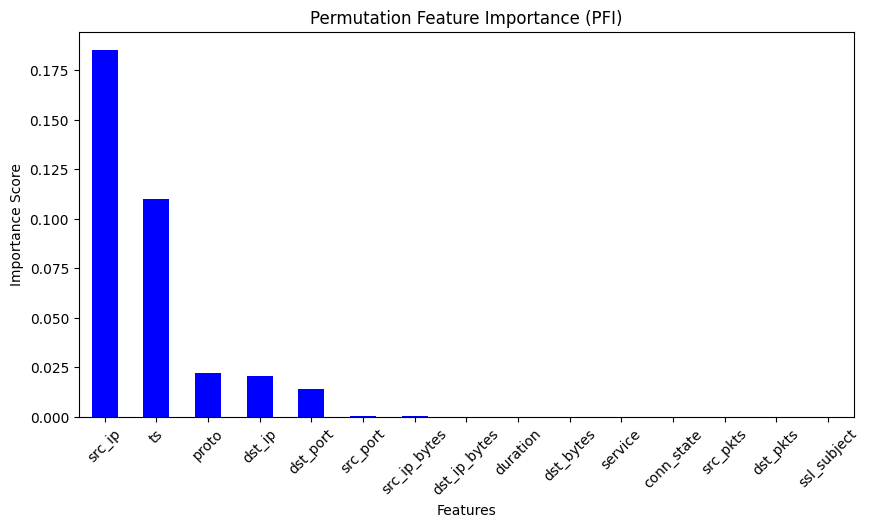

Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 245s 160ms/step - accuracy: 0.7761 - loss: 0.4016 - val_accuracy: 0.9178 - val_loss: 0.2190
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 260s 173ms/step - accuracy: 0.8779 - loss: 0.2700 - val_accuracy: 0.8957 - val_loss: 0.2504
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 262s 173ms/step - accuracy: 0.9080 - loss: 0.2190 - val_accuracy: 0.9528 - val_loss: 0.1483
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 262s 173ms/step - accuracy: 0.9507 - loss: 0.1425 - val_accuracy: 0.9475 - val_loss: 0.1353
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 261s 173ms/step - accuracy: 0.9547 - loss: 0.1244 - val_accuracy: 0.9665 - val_loss: 0.0949
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 63s 17ms/step
Model Performance Metrics:
Accuracy: 0.9658
Precision: 0.9872
Recall: 0.9439
F1-Score: 0.9650


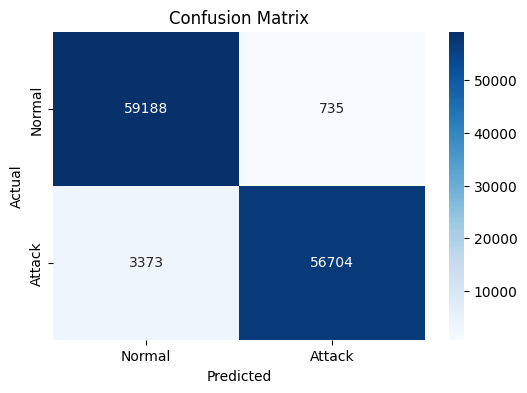


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     59923
           1       0.99      0.94      0.97     60077

    accuracy                           0.97    120000
   macro avg       0.97      0.97      0.97    120000
weighted avg       0.97      0.97      0.97    120000



In [11]:
if __name__ == "__main__":
    dataset_path = "/content/ToN_IoT_preprocessed.csv"  # Update with actual path
    data = load_dataset(dataset_path)
    X, y = preprocess_data(data)
    X_resampled, y_resampled = balance_data(X, y)
    X_selected, selected_features = feature_selection(X_resampled, y_resampled)
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y_resampled, test_size=0.2, random_state=42)
    X_train = np.expand_dims(X_train, axis=2)
    X_test = np.expand_dims(X_test, axis=2)
    model = build_lstm_model(X_train.shape[1])
    model.fit(X_train, y_train, epochs=5, batch_size=256, validation_split=0.2)
    evaluate_model(model, X_test, y_test)




In [12]:
import pandas as pd

data = pd.read_csv("ToN_IoT_preprocessed.csv")  # Ensure correct file path
print("Dataset shape:", data.shape)


Dataset shape: (461043, 44)
